In [5]:
import os
import sys
import random
import numpy as np

from tqdm import tqdm
from rdkit.Chem import AllChem
from rdkit.Chem.rdForceFieldHelpers import MMFFOptimizeMolecule

from openff.units.elements import SYMBOLS
from openff.toolkit import Molecule
from openff.recharge.conformers import ConformerGenerator, ConformerSettings
from source.storage.ddx_storage import ESPSettings, DDXSettings
from openff.recharge.esp.storage import MoleculeESPRecord, MoleculeESPStore
from openff.recharge.grids import LatticeGridSettings, GridSettingsType, GridGenerator
from openff.recharge.utilities.molecule import smiles_to_molecule
from qcelemental.models.procedures import OptimizationInput, QCInputSpecification
from openff.units import unit
from qcelemental.models.common_models import Model

import qcengine

sys.path.append('/Users/localadmin/Documents/projects/QM_ESP_Psi4')

from source.optimize.openff_psi4_gen import Psi4Generate
from source.conformers.conformer_gen import Conformers
from source.utilities.conversion_functions import conf_to_xyz_string


import psi4



In [ ]:
#load our molecule to create the conformers

molecule = smiles_to_molecule("OCC(O)CO")
rdmol = molecule.to_rdkit()
AllChem.EmbedMultipleConfs(rdmol, numConfs=10, randomSeed=42)

: 

In [ ]:
#test the optimizer

optimize_MMFF = MMFFOptimizeMolecule(rdmol,mmffVariant = 'MMFF94',confId=3) #,confId=1,mmffvariant='MMFF94'
optimize_MMFF



: 

In [ ]:
#test all the conformers

for id in range(rdmol.GetNumConformers()):
    optimize_MMFF = MMFFOptimizeMolecule(rdmol,mmffVariant = 'MMFF94',confId=3) #,confId=1,mmffvariant='MMFF94'
    print(f'conformer:{id}, optimize (0 = converge, 1 = more iterations req): {optimize_MMFF}')

: 

In [ ]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import py3Dmol


: 

In [ ]:
#do the conformers look structurally sensible

for id in range(rdmol.GetNumConformers()):
    IPythonConsole.drawMol3D(rdmol,confId=id)


: 

In [ ]:
optimize_MMFF

: 

In [ ]:
#now create a series of xyz files so we can run the conformers with ASE, first convert our conformers to xyz format and then write to file

from openff.units import unit

cwd = os.getcwd()

conformers = []



for confs in range(rdmol.GetNumConformers()):
    conformer = np.zeros((rdmol.GetConformer(confs).GetNumAtoms(), 3))
    for atom_index, coordinates in enumerate(rdmol.GetConformer(confs).GetPositions()):
        conformer[atom_index, :] = coordinates
    conformers.append(conformer * unit.angstrom)


for number ,conformer in enumerate(conformers):
    atoms = [
            {
                "element": SYMBOLS[atom.atomic_number],
                "x": conformer[index, 0],
                "y": conformer[index, 1],
                "z": conformer[index, 2],
            }
            for index, atom in enumerate(molecule.atoms)
        ]
    xyz = f'{molecule.n_atoms}\n{molecule.to_smiles()}\n'
    for row in atoms:
        xyz += f"{row['element']}\t{np.around(row['x'].magnitude,decimals=6)}\t{np.around(row['y'].magnitude,decimals=6)}\t{np.around(row['z'].magnitude, decimals=6)}\n"
    try:
        f = open(cwd+f"/conformer_{number}.xyz", 'x')
        f.write(xyz)
        f.close()
    except FileExistsError:
        continue

: 

In [2]:
esp_store = MoleculeESPStore('testdb.sqlite')

CWD = os.getcwd()

#generate water test molecule as openff.toolkit.Molecule
test_mol =  smiles_to_molecule('[H]O[H]')
conformer_list = Conformers.generate(test_mol, generation_type='rdkit')
conformer_list[0]
qc_mol =  test_mol.to_qcschema(conformer=0)

#Setup geometry optimisation
hf_model = Model(method="hf", basis="6-31G*")
spec = QCInputSpecification(model=hf_model, keywords={}, driver="gradient")
opt_spec = OptimizationInput(
            initial_molecule=qc_mol,
            input_specification=spec,
            keywords={"coordsys": "dlc", 
                      "program": "psi4"}                                        
        )

opt = qcengine.compute_procedure(opt_spec, "geometric")
print(f'geometry optimiztion was {opt.error}')
#return optimized molecule
optmized_mol = opt.final_molecule

#Generate grid.dat file for grid_esp and grid_field
grid_settings = LatticeGridSettings(
        type="fcc", spacing=0.5, inner_vdw_scale=1.4, outer_vdw_scale=2.0
    )

grid = GridGenerator.generate(test_mol, optmized_mol.geometry*unit.angstrom, grid_settings)

grid = grid.to(unit.angstrom).m
np.savetxt("grid.dat", grid, delimiter=" ", fmt="%16.10f")
#compute one-electron properties.
opt_input_2 = { "molecule" : optmized_mol,
              "driver" : "energy",
              "model" : {"method":"scf","basis":"6-31G*"},
              "protocols":{"wavefunction":"all","stdout":True,"native_files":"all"},
              "keywords":{"scf_properties":["GRID_ESP", "GRID_FIELD","MULLIKEN_CHARGES", "LOWDIN_CHARGES", "DIPOLE", "QUADRUPOLE", "MBIS_CHARGES"]}                               
              }


opt_2 = qcengine.compute(opt_input_2, "psi4", task_config={"scratch_directory":CWD,"scratch_messy":True})

print(opt_2.dict())

esp = (np.loadtxt("grid_esp.dat").reshape(-1, 1) * unit.hartree / unit.e)

electric_field = (np.loadtxt("grid_field.dat")* unit.hartree/ (unit.e * unit.bohr))

rdkit has generated 10 conformers from a requested 10 conformers


NameError: name 'Model' is not defined

In [ ]:
psi4.core.variables(['MBIS Charges'])

: 

In [4]:
from source.optimize.openff_psi4_gen import Psi4Generate
import psi4
import qcengine

test_mol =  smiles_to_molecule('[H]O[H]')

#generate water test molecule as openff.toolkit.Molecule
test_mol =  smiles_to_molecule('[H]O[H]')

conformer_list = Conformers.generate(test_mol, generation_type='rdkit')
conformer_list[0]
qc_mol =  test_mol.to_qcschema(conformer=0)

#Generate grid.dat file for grid_esp and grid_field
grid_settings = LatticeGridSettings(
        type="fcc", spacing=0.5, inner_vdw_scale=1.4, outer_vdw_scale=2.0
    )


esp_settings = ESPSettings(basis="6-31G*", method="hf", grid_settings=grid_settings)

xyz = Psi4Generate.run_calc(test_mol,conformer_list[0],esp_settings,compute_esp=True,compute_field=True, minimize=False)

molecule = psi4.geometry(
"""
3
[H]O[H]
H	-0.81024874	-0.18571238	-0.0
O	-0.00248133	0.36959931	-0.0
H	0.81273007	-0.18388693	0.0
"""
)

molecule.set_molecular_charge(0)
molecule.set_multiplicity(1)

E, wfn = psi4.energy('hf/6-31g*', return_wfn=True, molecule = molecule)
psi4.prop('hf/6-31G*', properties=["GRID_ESP", "GRID_FIELD","MULLIKEN_CHARGES", "LOWDIN_CHARGES", "DIPOLE", "QUADRUPOLE", "MBIS_CHARGES"])
#psi4.core.print_variables()
psi4.core.variables(['MBIS Charges'])
molecule.fcharge

rdkit has generated 10 conformers from a requested 10 conformers


AttributeError: type object 'Psi4Generate' has no attribute 'run_calc'

In [13]:
from source.optimize.openff_psi4_gen import Psi4Generate
from qcelemental.models.common_models import Model

test_mol =  smiles_to_molecule('[H]O[H]')

#generate water test molecule as openff.toolkit.Molecule
test_mol =  smiles_to_molecule('[H]O[H]')
conformer_list = Conformers.generate(test_mol, generation_type='rdkit')
conformer_list[0]
qc_mol =  test_mol.to_qcschema(conformer=0)



opt_spec = { "molecule" : qc_mol,
              "driver" : "gradient",
              "model" : {"method":"hf","basis":"6-31G*"}
            }

opt = qcengine.compute_procedure(opt_spec, "geometric", local_options = { "memory": 2000000, "ncores":4})
print(opt)
# print(opt.result)


rdkit has generated 10 conformers from a requested 10 conformers
FailedOperation(error=ComputeError(error_type='input_error', error_message="QCEngine Input Error: Error creating 'OptimizationInput', data could not be correctly parsed:\n5 validation errors for OptimizationInput\ninput_specification\n  field required (type=value_error.missing)\ninitial_molecule\n  field required (type=value_error.missing)\ndriver\n  extra fields not permitted (type=value_error.extra)\nmodel\n  extra fields not permitted (type=value_error.extra)\nmolecule\n  extra fields not permitted (type=value_error.extra)"))


/var/folders/5m/c625w21d6q3cgv41hc6yjs100000gq/T/ipykernel_18109/3519759898.py:19: FutureWarning: Using the `local_options` keyword argument is depreciated in favor of using `task_config`, in version 0.30.0 it will stop working.
  opt = qcengine.compute_procedure(opt_spec, "geometric", local_options = { "memory": 2000000, "ncores":4})


In [22]:
import os
import sys
import random
import numpy as np

from tqdm import tqdm
from rdkit.Chem import AllChem
from rdkit.Chem.rdForceFieldHelpers import MMFFOptimizeMolecule

from openff.units.elements import SYMBOLS
from openff.toolkit import Molecule
from openff.recharge.conformers import ConformerGenerator, ConformerSettings
from openff.storage.ddx_storage import ESPSettings

from openff.recharge.esp.storage import MoleculeESPRecord, MoleculeESPStore
from openff.recharge.grids import LatticeGridSettings, GridSettingsType, GridGenerator
from openff.recharge.utilities.molecule import smiles_to_molecule
from qcelemental.models.procedures import OptimizationInput, QCInputSpecification
from openff.units import unit
from qcelemental.models.common_models import Model

sys.path.append('/Users/localadmin/Documents/projects/QM_ESP_Psi4')

from source.optimize.openff_psi4_gen import Psi4Generate
from source.conformers.conformer_gen import Conformers
from source.utilities.conversion_functions import conf_to_xyz_string


import psi4

sys.settrace 

test_mol =  smiles_to_molecule('[H]O[H]')

#generate water test molecule as openff.toolkit.Molecule
test_mol =  smiles_to_molecule('[H]O[H]')
conformer_list = Conformers.generate(test_mol, generation_type='rdkit')
conformer_list[0]
qc_mol =  test_mol.to_qcschema(conformer=0)

#Generate grid.dat file for grid_esp and grid_field
grid_settings = LatticeGridSettings(
        type="fcc", spacing=0.5, inner_vdw_scale=1.4, outer_vdw_scale=2.0
    )
grid = GridGenerator.generate(test_mol, conformer_list[0], grid_settings)

grid = grid.to(unit.angstrom).m
np.savetxt("grid.dat", grid, delimiter=" ", fmt="%16.10f")


esp_settings = ESPSettings(basis="6-31G*", method="hf", grid_settings=grid_settings)

xyz = conformer_string = conf_to_xyz_string(conformer_list[0], test_mol)

psi4.set_output_file('output.dat')

molecule = psi4.core.Molecule.from_string("""
                                            nocom
                                            noreorient
                                            H	-0.81024874	-0.18571238	-0.0
                                            O	-0.00248133	0.36959931	-0.0
                                            H	0.81273007	-0.18388693	0.0 
                                          """)

molecule.set_molecular_charge(0)
molecule.set_multiplicity(1)

psi4.set_options({"DFT_SPHERICAL_POINTS":"590",
                  "DFT_RADIAL_POINTS":"99"})

E, wfn = psi4.prop('hf/6-31G*', properties=["GRID_ESP", 
                                            "GRID_FIELD",
                                            "MULLIKEN_CHARGES", 
                                            "LOWDIN_CHARGES", 
                                            "DIPOLE", 
                                            "QUADRUPOLE", 
                                            "MBIS_CHARGES"],
                                            molecule = molecule, 
                                            return_wfn = True,
                                            )  #"GRID_ESP", "GRID_FIELD"
psi4.core.variables(['MBIS Charges'])
wfn.variables()


rdkit has generated 10 conformers from a requested 10 conformers


{'CURRENT ENERGY': -76.00688623049763,
 'CURRENT REFERENCE ENERGY': -76.00688623049763,
 'DD SOLVATION ENERGY': 0.0,
 'HF KINETIC ENERGY': 75.71208232169353,
 'HF POTENTIAL ENERGY': -151.71896855219114,
 'HF TOTAL ENERGY': -76.00688623049763,
 'HF VIRIAL RATIO': 2.0038937498449916,
 'NUCLEAR REPULSION ENERGY': 8.941189202753957,
 'ONE-ELECTRON ENERGY': -122.62733060211329,
 'PCM POLARIZATION ENERGY': 0.0,
 'PE ENERGY': 0.0,
 'SCF ITERATION ENERGY': -76.00688623049763,
 'SCF ITERATIONS': 8.0,
 'SCF TOTAL ENERGY': -76.00688623049763,
 'TWO-ELECTRON ENERGY': 37.679255168861694,
 'HF DIPOLE': array([ 0.00408617, -0.83522958,  0.        ]),
 'HF QUADRUPOLE': array([[-2.78962776e+00,  4.75167568e-03,  0.00000000e+00],
        [ 4.75167568e-03, -5.40692800e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00, -5.41213293e+00]]),
 'LOWDIN CHARGES': array([ 0.36108223, -0.72231233,  0.3612301 ]),
 'MBIS CHARGES': array([[ 0.46457588],
        [-0.92803681],
        [ 0.46346084]]),


In [23]:
E

-76.00688623049763

In [ ]:
wfn.variables()

: 

In [ ]:
molecule = psi4.core.Molecule.from_string("""
                                            nocom
                                            noreorient
                                            H	-0.81024874	-0.18571238	-0.0
                                            O	-0.00248133	0.36959931	-0.0
                                            H	0.81273007	-0.18388693	0.0 
                                          """)

molecule.to_string('xyz')


: 

In [51]:
mulliken_charges = wfn.variable("MULLIKEN_CHARGES")
lowdin_charges = wfn.variable("LOWDIN_CHARGES")
dipole = wfn.variable("HF DIPOLE")
quadrupole = wfn.variable("HF QUADRUPOLE")
mbis_charges = wfn.variable("MBIS CHARGES")
mbis_dipole = wfn.variable("MBIS DIPOLES")
mbis_quadropole = wfn.variable("MBIS QUADRUPOLES")
mbis_octopoles = wfn.variable("MBIS OCTUPOLES")

/var/folders/5m/c625w21d6q3cgv41hc6yjs100000gq/T/ipykernel_61022/1490584054.py:1: FutureWarning: Using QCVariable `MULLIKEN_CHARGES` instead of `MULLIKEN CHARGES` is deprecated, and as soon as 1.5 it will stop working

  mulliken_charges = wfn.variable("MULLIKEN_CHARGES")
/var/folders/5m/c625w21d6q3cgv41hc6yjs100000gq/T/ipykernel_61022/1490584054.py:2: FutureWarning: Using QCVariable `LOWDIN_CHARGES` instead of `LOWDIN CHARGES` is deprecated, and as soon as 1.5 it will stop working

  lowdin_charges = wfn.variable("LOWDIN_CHARGES")


In [55]:
wfn.variable("MBIS Radial Moments")

KeyError: "psi4.core.Wavefunction.variable: Requested variable 'MBIS Radial Moments' was not set!\n"

In [52]:
mbis_quadropole

array([[[-2.44526441e-01, -1.92142965e-03,  2.42888104e-16],
        [-1.92142965e-03, -2.40525249e-01,  9.65235043e-16],
        [ 2.42888104e-16,  9.65235043e-16, -2.49256924e-01]],

       [[-4.60488438e+00,  6.33244257e-04,  1.50421516e-15],
        [ 6.33244257e-04, -4.77221371e+00,  3.49333554e-15],
        [ 1.50421516e-15,  3.49333554e-15, -4.91111602e+00]],

       [[-2.46903142e-01,  1.82558118e-03, -1.49853864e-16],
        [ 1.82558118e-03, -2.42847379e-01,  1.27428000e-15],
        [-1.49853864e-16,  1.27428000e-15, -2.51759608e-01]]])

In [ ]:
variable_names = ["MULLIKEN_CHARGES", "LOWDIN_CHARGES", "HF DIPOLE", "HF QUADRUPOLE", "MBIS CHARGES"]
variables = {name: wfn.variable(name) for name in variable_names}

: 

In [ ]:
from qcelemental.models import Molecule as QCMol
qc_mol =  test_mol.to_qcschema(conformer=0)
qc_mol = QCMol(**qc_mol.dict(exclude={"fix_com", "fix_orientation"}), fix_com=True, fix_orientation=True)
molecule = psi4.geometry(qc_mol.to_string("psi4"))
qc_mol.geometry

: 

In [2]:
import sys
import os
CWD = os.getcwd()
sys.path.append(os.path.dirname(CWD))

from source.inputSetup.SmilesInputs import ReadInput
from source.optimize.esp_generator_wrapper import ESPGenerator, PropGenerator
from source.conformers.conformer_gen import Conformers
from openff.recharge.utilities.molecule import smiles_to_molecule
from openff.recharge.grids import LatticeGridSettings
from openff.storage.ddx_storage import ESPSettings




    
#Read the .smi input and add to list
smiles = ReadInput.read_smiles('test_files.smi')

# Define the grid that the electrostatic properties will be trained on and the
# level of theory to compute the properties at.
grid_settings = LatticeGridSettings(
    type="fcc", spacing=0.5, inner_vdw_scale=1.4, outer_vdw_scale=2.0
)

esp_settings = ESPSettings(basis="6-31G*", method="hf", grid_settings=grid_settings)

#Loop through molecules
for mol in smiles:
    molecule = smiles_to_molecule(mol)
    #Generate the conformers
    conformer_list = Conformers.generate(molecule, generation_type='rdkit')
    ESP_gen = PropGenerator(molecule = molecule, conformers = conformer_list, esp_settings = esp_settings, grid_settings = grid_settings)
    ESP_gen.memory = 2e+9 #2gb
    print(f'number of cores is {ESP_gen.ncores}')
    print(f'memory is {ESP_gen.memory}')
    ESP_gen.run_props()
    #ESP_gen.fetch_data()

rdkit has generated 10 conformers from a requested 10 conformers


/Users/localadmin/Documents/projects/QM_ESP_Psi4/source/optimize/esp_generator_wrapper.py:147: FutureWarning: Using the `local_options` keyword argument is depreciated in favor of using `task_config`, in version 0.30.0 it will stop working.
  opt = qcengine.compute_procedure(opt_spec, "geometric", local_options = { "memory": self.memory, "ncores": self.ncores})


number of cores is 4
memory is 2000000000.0
conformer 0 for [H][O][C]([H])([H])[C]([H])([O][H])[C]([H])([H])[O][H]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Int

KeyboardInterrupt: 

In [6]:
import psi4
psi4.set_memory('2gb')


  Memory set to   1.863 GiB by Python driver.


2000000000

In [4]:
variables_dict = {'MULLIKEN_CHARGES': np.array([-0.73734578, -0.02447919,  0.11756134, -0.73731244,  0.0087507 ,
       -0.73499064,  0.43804742,  0.18581185,  0.14089697,  0.1203388 ,
        0.43975199,  0.18330349,  0.16756023,  0.43210525]), 'LOWDIN_CHARGES': np.array([-0.52128412, -0.10109616,  0.00531395, -0.5040507 , -0.09043403,
       -0.5125839 ,  0.35640563,  0.15199032,  0.11833242,  0.10783985,
        0.35337187,  0.15071365,  0.13581654,  0.34966469]), 'HF DIPOLE': np.array([-1.04266932, -0.2294717 , -1.13023893]), 'HF QUADRUPOLE': np.array([[-31.86914081,  -4.25065534,   2.02651926],
       [ -4.25065534, -27.07297069,   1.47545515],
       [  2.02651926,   1.47545515, -23.87739699]]), 'MBIS CHARGES': np.array([[-0.68146552],
       [ 0.11369298],
       [ 0.10728801],
       [-0.65628907],
       [ 0.14327947],
       [-0.673989  ],
       [ 0.44975509],
       [ 0.08898321],
       [ 0.03800309],
       [ 0.03757985],
       [ 0.44693836],
       [ 0.08720612],
       [ 0.05736164],
       [ 0.44166793]])}

In [2]:
import sys
import os
CWD = os.getcwd()
sys.path.append(os.path.dirname(CWD))

from openff.recharge.esp.storage import MoleculeESPRecord, MoleculeESPStore
from source.storage.storage import MoleculePropRecord, MoleculePropStore
prop_store = MoleculePropStore("prop-store.sqlite")

In [3]:
smiles_list = prop_store.list()
smiles_list

[]

In [4]:
prop_store.retrieve(smiles_list[0])[0].grid_coordinates


IndexError: list index out of range

In [ ]:
prop_store.retrieve(smiles_list[0])

[MoleculePropRecord(tagged_smiles='[O:1]([C:2]([C:3]([O:4][H:11])([C:5]([O:6][H:14])([H:12])[H:13])[H:10])([H:8])[H:9])[H:7]', conformer=array([[-1.74483703e+00, -1.16923060e+00,  3.52914901e-01],
        [-1.30043753e+00,  1.60682346e-01,  3.88060241e-01],
        [ 5.52571638e-02,  3.46731501e-01, -2.91818903e-01],
        [ 3.85542160e-01,  1.70943527e+00, -3.26207642e-01],
        [ 1.16166035e+00, -3.80040506e-01,  4.56204039e-01],
        [ 2.37386480e+00, -4.03906825e-01, -2.44070689e-01],
        [-2.03999392e+00, -1.38608172e+00, -5.20295999e-01],
        [-1.22258478e+00,  4.37792816e-01,  1.43130355e+00],
        [-2.02864702e+00,  8.28642019e-01, -6.89099802e-02],
        [-1.42782310e-03, -5.67833524e-02, -1.30592730e+00],
        [-1.30197132e-01,  2.15553406e+00, -9.82944742e-01],
        [ 1.35308642e+00,  1.49434039e-01,  1.38025050e+00],
        [ 8.29012242e-01, -1.38378347e+00,  7.01182150e-01],
        [ 2.30970210e+00, -1.00842557e+00, -9.69740128e-01]]), grid_coo

In [ ]:
prop_store.retrieve(smiles_list[0])[0].mulliken_charges


array([-0.73734578, -0.02447918,  0.11756132, -0.73731242,  0.00875072,
       -0.73499063,  0.43804742,  0.18581185,  0.14089697,  0.1203388 ,
        0.43975199,  0.18330348,  0.16756022,  0.43210525])

In [ ]:
prop_store.retrieve(smiles_list[0])[0].dipole


array([-1.04266946, -0.22947154, -1.13023897])

In [ ]:
prop_store.retrieve(smiles_list[0])[0].lowdin_charges


array([-0.52128413, -0.10109615,  0.00531394, -0.50405069, -0.09043403,
       -0.51258389,  0.35640563,  0.15199032,  0.11833241,  0.10783985,
        0.35337186,  0.15071365,  0.13581653,  0.34966469])

In [ ]:
prop_store.retrieve(smiles_list[0])[0].mbis_charges


array([[-0.68146552],
       [ 0.11369298],
       [ 0.10728799],
       [-0.65628906],
       [ 0.14327948],
       [-0.67398898],
       [ 0.44975509],
       [ 0.08898321],
       [ 0.03800308],
       [ 0.03757985],
       [ 0.44693835],
       [ 0.08720612],
       [ 0.05736163],
       [ 0.44166793]])

In [ ]:
prop_store.retrieve(smiles_list[0])[0].mbis_dipole


array([[ 0.0423795 ,  0.0817365 ,  0.05666081],
       [-0.05116511, -0.14980226,  0.02349646],
       [ 0.06343287,  0.14716018, -0.01750751],
       [ 0.02628692, -0.1043703 ,  0.04596402],
       [ 0.14679028,  0.03395472, -0.07640193],
       [-0.0600789 ,  0.05742006,  0.07224618],
       [-0.00598221, -0.00342261, -0.01568646],
       [ 0.01066748,  0.00523096,  0.05522062],
       [-0.03693496,  0.03396674, -0.02735309],
       [ 0.00163061, -0.01944368, -0.04329387],
       [-0.00911471,  0.0086815 , -0.01317768],
       [ 0.01731748,  0.04047856,  0.03870743],
       [-0.02388052, -0.05645075,  0.01054764],
       [-0.00111479, -0.01127107, -0.01302382]])

In [ ]:
mbis_array = prop_store.retrieve(smiles_list[-1])[0].mbis_charges.flatten()

In [ ]:
muliken_array = prop_store.retrieve(smiles_list[-1])[0].mulliken_charges

In [ ]:
lowdin_array = prop_store.retrieve(smiles_list[-1])[0].lowdin_charges

In [ ]:
prop_store.retrieve(smiles_list[-1])[0].tagged_smiles


'[H:1][C:2]1=[C:3]([H:9])[S:4][C:5]([H:8])=[C:6]1[H:7]'

In [ ]:
prop_store.retrieve(smiles_list[-1])[0].dipole


array([-0.00540298, -0.35337431, -0.01537461])

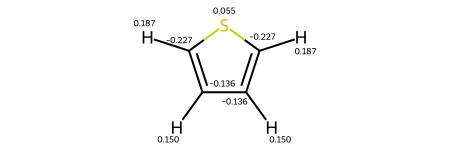

In [ ]:
from rdkit import Chem;
sulfur_mol = Molecule.from_mapped_smiles(prop_store.retrieve(smiles_list[-1])[0].tagged_smiles)
sulfur_mol_rdkit = sulfur_mol.to_rdkit()
for i,atoms in enumerate(sulfur_mol_rdkit.GetAtoms()):
    lbl = '%.3f'%(mbis_array[i])
    atoms.SetProp('atomNote',lbl)
    
sulfur_mol_rdkit

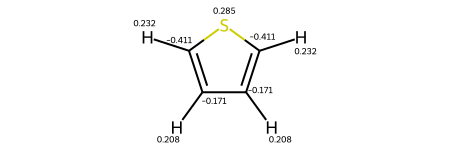

In [ ]:
for i,atoms in enumerate(sulfur_mol_rdkit.GetAtoms()):
    lbl = '%.3f'%(muliken_array[i])
    atoms.SetProp('atomNote',lbl)
sulfur_mol_rdkit

In [1]:
import sys
import os
CWD = os.getcwd()
sys.path.append(os.path.dirname(CWD))

from openff.recharge.esp.storage import MoleculeESPRecord, MoleculeESPStore
from source.storage.storage import MoleculePropRecord, MoleculePropStore

prop_test = MoleculePropStore("/Users/localadmin/Documents/projects/QM_ESP_Psi4/examples/prop_test_2.db")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
smiles_list = prop_test.list()
smiles_list

['OCC(O)CO',
 'C#CC',
 'C1CN1',
 'C1COC1',
 'CC#N',
 'CC(=O)[O-]',
 'CC(C)=O',
 'CCCC',
 'CCNCC',
 'CN(C)C',
 'CN=[N+]=[N-]',
 'CNC',
 'COC',
 'CSC',
 'Fc1ccccc1',
 'NCO',
 'Nc1ccccc1',
 'O=[NH+][O-]',
 'Oc1ccccc1',
 'CCl',
 'CF',
 'CO',
 'CS',
 'C1COCO1',
 'c1ccccc1',
 'c1ccncc1',
 'c1ccsc1']

In [3]:
prop_test.retrieve(smiles_list[-1])[0].charge_model_charges

In [6]:

mapped_smiles = prop_test.retrieve(smiles_list[-1])[0].tagged_smiles
print(mapped_smiles)
charge_mol_am1bcc = Molecule.from_mapped_smiles(mapped_smiles)
charge_mol_am1bcc.assign_partial_charges('mmff94', use_conformers=[prop_test.retrieve(smiles_list[-1])[0].conformer_quantity])
charge_mol_am1bcc_list = charge_mol_am1bcc.partial_charges
charge_mol_am1bcc_list

[H:1][C:2]1=[C:3]([H:9])[S:4][C:5]([H:8])=[C:6]1[H:7]


Magnitude,[0.15 -0.15 -0.10999999999999999 -0.08 -0.10999999999999999 -0.15 0.15 0.15 0.15]
Units,elementary_charge


In [7]:
prop_test.store_partial(smiles=mapped_smiles,
                        conformer=prop_test.retrieve(smiles_list[-1])[0].conformer,
                        charge_model= 'zeros',
                        charges=charge_mol_am1bcc_list)

prop_test.retrieve_partial(smiles=mapped_smiles,
                           conformer=prop_test.retrieve(smiles_list[-1])[0].conformer)

{'mmff94': [0.15,
  -0.15,
  -0.10999999999999999,
  -0.08,
  -0.10999999999999999,
  -0.15,
  0.15,
  0.15,
  0.15],
 'zeros': [0.15,
  -0.15,
  -0.10999999999999999,
  -0.08,
  -0.10999999999999999,
  -0.15,
  0.15,
  0.15,
  0.15]}

In [12]:
prop_test.retrieve(smiles_list[0])[0]

MoleculePropRecord(tagged_smiles='[O:1]([C:2]([C:3]([O:4][H:11])([C:5]([O:6][H:14])([H:12])[H:13])[H:10])([H:8])[H:9])[H:7]', conformer=array([[-1.74483717e+00, -1.16923060e+00,  3.52914751e-01],
       [-1.30043745e+00,  1.60682281e-01,  3.88060305e-01],
       [ 5.52572148e-02,  3.46731476e-01, -2.91818870e-01],
       [ 3.85542074e-01,  1.70943527e+00, -3.26207719e-01],
       [ 1.16166040e+00, -3.80040443e-01,  4.56204088e-01],
       [ 2.37386482e+00, -4.03906723e-01, -2.44070740e-01],
       [-2.03999415e+00, -1.38608151e+00, -5.20296182e-01],
       [-1.22258471e+00,  4.37792559e-01,  1.43130366e+00],
       [-2.02864692e+00,  8.28642073e-01, -6.89097897e-02],
       [-1.42782733e-03, -5.67834309e-02, -1.30592724e+00],
       [-1.30197184e-01,  2.15553394e+00, -9.82944930e-01],
       [ 1.35308643e+00,  1.49434130e-01,  1.38025051e+00],
       [ 8.29012288e-01, -1.38378339e+00,  7.01182193e-01],
       [ 2.30970220e+00, -1.00842563e+00, -9.69740037e-01]]), grid_coordinates=array

In [13]:
import sys
import os
CWD = os.getcwd()
sys.path.append(os.path.dirname(CWD))

from openff.recharge.esp.storage import MoleculeESPRecord, MoleculeESPStore
from source.storage.storage import MoleculePropRecord, MoleculePropStore

prop_store = MoleculePropStore("/Users/localadmin/Documents/projects/QM_ESP_Psi4/properties_store.db")

In [14]:
prop_store.list()

['OCC(O)CO',
 'C#CC',
 'C1CN1',
 'C1COC1',
 'CC#N',
 'CC(=O)[O-]',
 'CC(C)=O',
 'CCCC',
 'CCNCC',
 'CN(C)C',
 'CN=[N+]=[N-]',
 'CNC',
 'COC',
 'CSC',
 'Fc1ccccc1',
 'NCO',
 'Nc1ccccc1',
 'O=[NH+][O-]',
 'Oc1ccccc1',
 'CCl',
 'CF',
 'CO',
 'CS',
 'C1COCO1',
 'c1ccccc1',
 'c1ccncc1',
 'c1ccsc1']

In [16]:
prop_store.retrieve_partial(smiles=prop_store.)

MoleculePropRecord(tagged_smiles='[O:1]([C:2]([C:3]([O:4][H:11])([C:5]([O:6][H:14])([H:12])[H:13])[H:10])([H:8])[H:9])[H:7]', conformer=array([[-1.74483717e+00, -1.16923047e+00,  3.52915111e-01],
       [-1.30043747e+00,  1.60682425e-01,  3.88060227e-01],
       [ 5.52572052e-02,  3.46731346e-01, -2.91818959e-01],
       [ 3.85542282e-01,  1.70943510e+00, -3.26207861e-01],
       [ 1.16166033e+00, -3.80040665e-01,  4.56204066e-01],
       [ 2.37386492e+00, -4.03906578e-01, -2.44070448e-01],
       [-2.03999420e+00, -1.38608159e+00, -5.20295724e-01],
       [-1.22258476e+00,  4.37793005e-01,  1.43130349e+00],
       [-2.02864693e+00,  8.28642072e-01, -6.89100770e-02],
       [-1.42786564e-03, -5.67835820e-02, -1.30592730e+00],
       [-1.30197209e-01,  2.15553390e+00, -9.82944781e-01],
       [ 1.35308615e+00,  1.49433644e-01,  1.38025067e+00],
       [ 8.29012354e-01, -1.38378373e+00,  7.01181821e-01],
       [ 2.30970237e+00, -1.00842489e+00, -9.69740233e-01]]), grid_coordinates=array